参考资料：
http://nlp.seas.harvard.edu/2018/04/03/attention.html
https://blog.csdn.net/longxinchen_ml/article/details/86533005
https://zhuanlan.zhihu.com/p/48508221

@inproceedings{opennmt,
  author    = {Guillaume Klein and
               Yoon Kim and
               Yuntian Deng and
               Jean Senellart and
               Alexander M. Rush},
  title     = {OpenNMT: Open-Source Toolkit for Neural Machine Translation},
  booktitle = {Proc. ACL},
  year      = {2017},
  url       = {https://doi.org/10.18653/v1/P17-4012},
  doi       = {10.18653/v1/P17-4012}
}

In [1]:
# 需求包
# !pip install http://download.pytorch.org/whl/cu80/torch-0.3.0.post4-cp36-cp36m-linux_x86_64.whl numpy matplotlib spacy torchtext seaborn 

In [4]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import math, copy, time
from torch.autograd import Variable
import matplotlib.pyplot as plt
import seaborn
seaborn.set_context(context="talk")
%matplotlib inline

In [5]:
class EncoderDecoder(nn.Module):
    """
    A standard Encoder-Decoder architecture. Base for this and many 
    other models.
    标准的Encoder-Decoder结构，整体架构的形式化定义。
    """
    def __init__(self, encoder, decoder, src_embed, tgt_embed, generator):
        """
        构造函数的参数：encoder函数，decoder函数，源embed,目标embed，生成器（生成训练数据）
        """
        super(EncoderDecoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.src_embed = src_embed
        self.tgt_embed = tgt_embed
        self.generator = generator
        
    def forward(self, src, tgt, src_mask, tgt_mask):
        "Take in and process masked src and target sequences."
        "定义前向传播过程"
        return self.decode(self.encode(src, src_mask), src_mask,
                            tgt, tgt_mask)
    
    def encode(self, src, src_mask):
        return self.encoder(self.src_embed(src), src_mask)
    
    def decode(self, memory, src_mask, tgt, tgt_mask):
        return self.decoder(self.tgt_embed(tgt), memory, src_mask, tgt_mask)

In [6]:
class Generator(nn.Module):
    """Define standard linear + softmax generation step.
     简单的线性层
    """
    def __init__(self, d_model, vocab):
        super(Generator, self).__init__()
        self.proj = nn.Linear(d_model, vocab)

    def forward(self, x):
        return F.log_softmax(self.proj(x), dim=-1)

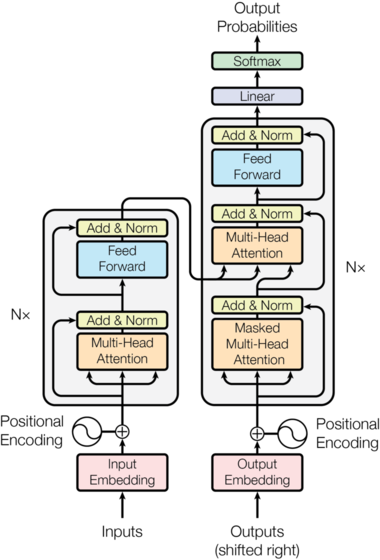

In [7]:
def clones(module, N):
    "Produce N identical layers. 用于重复堆叠层次（encoder）"
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

In [8]:
class Encoder(nn.Module):
    """
    Core encoder is a stack of N layers
    encoder是6个相同的layer堆叠而成的，前向传播的时候循环6次
    """
    def __init__(self, layer, N):
        super(Encoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)
        
    def forward(self, x, mask):
        
        for layer in self.layers:
            x = layer(x, mask)
        return self.norm(x)

In [9]:
class LayerNorm(nn.Module):
    "Construct a layernorm module (See citation for details)."
    """
        "Construct a layernorm module ."
        layer norm层，用于提高泛化能力（注意区别Layer norm 和 batch norm）
    """
    def __init__(self, features, eps=1e-6):
        super(LayerNorm, self).__init__()
        self.a_2 = nn.Parameter(torch.ones(features))
        self.b_2 = nn.Parameter(torch.zeros(features))
        self.eps = eps

    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        return self.a_2 * (x - mean) / (std + self.eps) + self.b_2

In [10]:
class SublayerConnection(nn.Module):
    """
    A residual connection followed by a layer norm.
    Note for code simplicity the norm is first as opposed to last.
    直接连接+LN+dropout
    """
    def __init__(self, size, dropout):
        super(SublayerConnection, self).__init__()
        self.norm = LayerNorm(size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, sublayer):
        "Apply residual connection to any sublayer with the same size."
        "残差连接（需要控制x和dropout的输出维度相同）"
        return x + self.dropout(sublayer(self.norm(x)))

In [11]:
clones(SublayerConnection(1, 0.1), 2)


ModuleList(
  (0): SublayerConnection(
    (norm): LayerNorm()
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (1): SublayerConnection(
    (norm): LayerNorm()
    (dropout): Dropout(p=0.1, inplace=False)
  )
)

In [12]:
class EncoderLayer(nn.Module):
    """
    Encoder is made up of self-attn and feed forward (defined below)
    Encoder层（Encoder里面Layer的具体定义），由self-attention + feed forward + 全连接处理构成
    
    """
    def __init__(self, size, self_attn, feed_forward, dropout):
        super(EncoderLayer, self).__init__()
        self.self_attn = self_attn#注意力
        self.feed_forward = feed_forward#全连接层
        self.sublayer = clones(SublayerConnection(size, dropout), 2)#直接连接、正则化层*2
        self.size = size

    def forward(self, x, mask):
        "Follow Figure 1 (left) for connections."  
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, mask))
        #lambda :用于自定义函数（x=self.self_attn(x, x, x, mask)）
        #sublayer定义了两层的Norm层，在attention和全连接层之后分别接一个
        return self.sublayer[1](x, self.feed_forward)

In [13]:
class Decoder(nn.Module):
    """
    Generic N layer decoder with masking.
    decoder整体模块，这里有masking机制。
    """
    def __init__(self, layer, N):
        super(Decoder, self).__init__()
        self.layers = clones(layer, N)#N个单层
        self.norm = LayerNorm(layer.size)#相应的Norm层
        
    def forward(self, x, memory, src_mask, tgt_mask):
        for layer in self.layers:
            x = layer(x, memory, src_mask, tgt_mask)
        return self.norm(x)

In [14]:
class DecoderLayer(nn.Module):
    "Decoder is made of self-attn, src-attn, and feed forward (defined below)"
    """
    decoder单层，包含self-atttention、encoder-decoder attention和feed forward三层，以及相应的三层norm层
    """
    def __init__(self, size, self_attn, src_attn, feed_forward, dropout):
        super(DecoderLayer, self).__init__()
        self.size = size
        self.self_attn = self_attn
        self.src_attn = src_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 3)
 
    def forward(self, x, memory, src_mask, tgt_mask):
        "Follow Figure 1 (right) for connections."
        m = memory#memory的作用：是encoder的中间状态，用于计算src_attention
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, tgt_mask))
        x = self.sublayer[1](x, lambda x: self.src_attn(x, m, m, src_mask))
        return self.sublayer[2](x, self.feed_forward)

In [16]:
def subsequent_mask(size):
    "Mask out subsequent positions."
    """
    mask过程，生成一个三角矩阵，如下图所示，黄色-True,紫色-False
    用于decode过程（一次生成一个位置的结果），将tgt_input输入中已经生成之外的位置进行mask
    """
    attn_shape = (1, size, size)
    subsequent_mask = np.triu(np.ones(attn_shape), k=1).astype('uint8')
    return torch.from_numpy(subsequent_mask) == 0

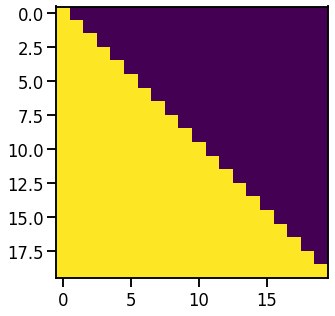

In [17]:
plt.figure(figsize=(5,5))
plt.imshow(subsequent_mask(20)[0])

In [42]:
def attention(query, key, value, mask=None, dropout=None):
    "Compute 'Scaled Dot Product Attention'"
    """
    用点乘计算相似度，softmax归一化，和value结合计算self-attention
    关于torch.matmul/bmm/mm，可以参考
    https://blog.csdn.net/leo_95/article/details/89946318?utm_medium=distribute.pc_relevant_t0.none-task-blog-BlogCommendFromMachineLearnPai2-1.control&dist_request_id=1328602.58314.16151871048886699&depth_1-utm_source=distribute.pc_relevant_t0.none-task-blog-BlogCommendFromMachineLearnPai2-1.control
    """
    
    #tensor.size的用法:获取tensor的维度，-1为倒数第一维
    d_k = query.size(-1)
    #print('dk',d_k,math.sqrt(d_k))
    #print('key.trans',key.transpose(-2, -1))
    
    #tensor.transpose:将选定的两个维度交换
    scores = torch.matmul(query, key.transpose(-2, -1)) \
             / math.sqrt(d_k)
    
    #print('mask前',scores)
    
    #torch.masked_fill:用value填充满足mask==0位置的值（上图紫色部分）
    if mask is not None:
        scores = scores.masked_fill(mask == 0, -1e9)
    #print('mask后',scores)
    p_attn = F.softmax(scores, dim = -1)
    if dropout is not None:
        p_attn = dropout(p_attn)
    return torch.matmul(p_attn, value), p_attn

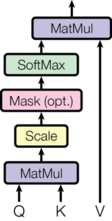

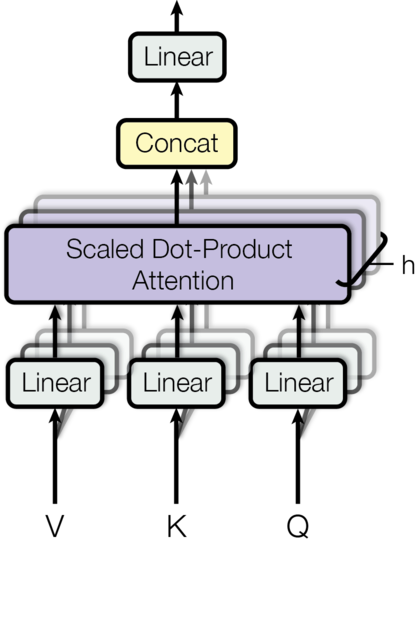

In [43]:
class MultiHeadedAttention(nn.Module):
    def __init__(self, h, d_model, dropout=0.1):
        "Take in model size and number of heads."
        """
        多源注意力层的实现
        h个源头（不同的注意力）,结果表示用concat连接
        """
        super(MultiHeadedAttention, self).__init__()
        assert d_model % h == 0
        # We assume d_v always equals d_k
        #整除确认
        self.d_k = d_model // h
        self.h = h
        self.linears = clones(nn.Linear(d_model, d_model), 4)
        self.attn = None
        self.dropout = nn.Dropout(p=dropout)
        
    def forward(self, query, key, value, mask=None):
        "Implements Figure 2"
        if mask is not None:
            # Same mask applied to all h heads.
            mask = mask.unsqueeze(1)
        nbatches = query.size(0)
        
        # 1) Do all the linear projections in batch from d_model => h x d_k 
        #这里对三个输入矩阵做了变形，-1表示自动适应维度（变形前后元素数量不变）
        #print(query.size(),key.size(),value.size())
        #print(self.linears)
        #for l, x in zip(self.linears, (query, key, value)):
         #   print(l)
          #  print(x)
           # print(l(x))
        
        query, key, value = \
            [l(x).view(nbatches, -1, self.h, self.d_k).transpose(1, 2)
             for l, x in zip(self.linears, (query, key, value))]
        
        # 2) Apply attention on all the projected vectors in batch. 
        #print(query.size(),key.size(),value.size())
        x, self.attn = attention(query, key, value, mask=mask, 
                                 dropout=self.dropout)
        
        # 3) "Concat" using a view and apply a final linear. 
        x = x.transpose(1, 2).contiguous() \
             .view(nbatches, -1, self.h * self.d_k)
        return self.linears[-1](x)

In [22]:
class PositionwiseFeedForward(nn.Module):
    "Implements FFN equation. 正常的feed forward"
    def __init__(self, d_model, d_ff, dropout=0.1):
        super(PositionwiseFeedForward, self).__init__()
        self.w_1 = nn.Linear(d_model, d_ff)
        self.w_2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        return self.w_2(self.dropout(F.relu(self.w_1(x))))

In [23]:
class Embeddings(nn.Module):
    "Embedding层"
    def __init__(self, d_model, vocab):
        super(Embeddings, self).__init__()
        self.lut = nn.Embedding(vocab, d_model)
        self.d_model = d_model

    def forward(self, x):
        return self.lut(x) * math.sqrt(self.d_model)

In [24]:
class PositionalEncoding(nn.Module):
    "Implement the PE function."
    "位置编码 用于编码顺序"
    def __init__(self, d_model, dropout, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        
        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) *
                             -(math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)
        
    def forward(self, x):
        x = x + Variable(self.pe[:, :x.size(1)], 
                         requires_grad=False)
        return self.dropout(x)

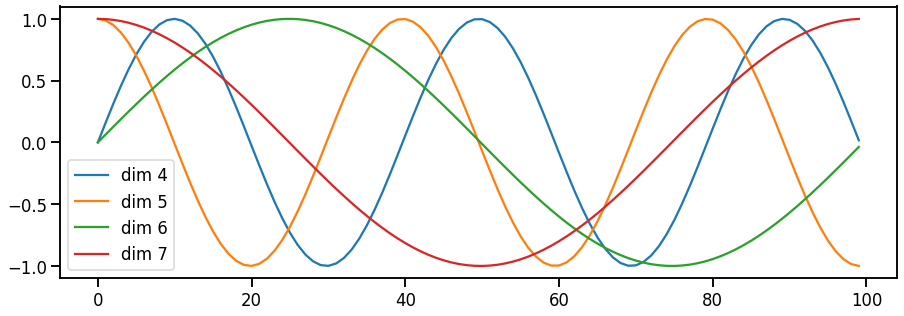

In [25]:
plt.figure(figsize=(15, 5))
pe = PositionalEncoding(20, 0)
y = pe.forward(Variable(torch.zeros(1, 100, 20)))
plt.plot(np.arange(100), y[0, :, 4:8].data.numpy())
plt.legend(["dim %d"%p for p in [4,5,6,7]])

In [26]:
def make_model(src_vocab, tgt_vocab, N=6, 
               d_model=512, d_ff=2048, h=8, dropout=0.1):
    "Helper: Construct a model from hyperparameters."
    "构建模型pipeline"
    c = copy.deepcopy
    attn = MultiHeadedAttention(h, d_model)
    ff = PositionwiseFeedForward(d_model, d_ff, dropout)
    position = PositionalEncoding(d_model, dropout)
    model = EncoderDecoder(
        Encoder(EncoderLayer(d_model, c(attn), c(ff), dropout), N),
        Decoder(DecoderLayer(d_model, c(attn), c(attn), 
                             c(ff), dropout), N),
        nn.Sequential(Embeddings(d_model, src_vocab), c(position)),
        nn.Sequential(Embeddings(d_model, tgt_vocab), c(position)),
        Generator(d_model, tgt_vocab))
    
    # This was important from their code. 
    # Initialize parameters with Glorot / fan_avg.
    for p in model.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform(p)
    return model

In [27]:
tmp_model = make_model(10, 10, 2)

<ipython-input-26-8c4144c2405f>:20: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(p)


In [28]:
class Batch:
    "Object for holding a batch of data with mask during training."
    "训练时用于控制批次"
    def __init__(self, src, trg=None, pad=0):
        self.src = src
        self.src_mask = (src != pad).unsqueeze(-2)
        if trg is not None:
            self.trg = trg[:, :-1]
            self.trg_y = trg[:, 1:]
            self.trg_mask = \
                self.make_std_mask(self.trg, pad)
            self.ntokens = (self.trg_y != pad).data.sum()
    
    @staticmethod
    def make_std_mask(tgt, pad):
        "Create a mask to hide padding and future words."
        tgt_mask = (tgt != pad).unsqueeze(-2)
        tgt_mask = tgt_mask & Variable(
            subsequent_mask(tgt.size(-1)).type_as(tgt_mask.data))
        return tgt_mask

In [29]:
def run_epoch(data_iter, model, loss_compute):
    "Standard Training and Logging Function"
    "跑数据"
    start = time.time()
    total_tokens = 0
    total_loss = 0
    tokens = 0
    for i, batch in enumerate(data_iter):
        out = model.forward(batch.src, batch.trg, 
                            batch.src_mask, batch.trg_mask)
        loss = loss_compute(out, batch.trg_y, batch.ntokens)
        total_loss += loss
        total_tokens += batch.ntokens
        tokens += batch.ntokens
        if i % 50 == 1:
            elapsed = time.time() - start
            print("Epoch Step: %d Loss: %f Tokens per Sec: %f" %
                    (i, loss / batch.ntokens, tokens / elapsed))
            start = time.time()
            tokens = 0
    return total_loss / total_tokens

In [30]:
global max_src_in_batch, max_tgt_in_batch
def batch_size_fn(new, count, sofar):
    "Keep augmenting batch and calculate total number of tokens + padding."
    global max_src_in_batch, max_tgt_in_batch
    if count == 1:
        max_src_in_batch = 0
        max_tgt_in_batch = 0
    max_src_in_batch = max(max_src_in_batch,  len(new.src))
    max_tgt_in_batch = max(max_tgt_in_batch,  len(new.trg) + 2)
    src_elements = count * max_src_in_batch
    tgt_elements = count * max_tgt_in_batch
    return max(src_elements, tgt_elements)

In [31]:
class NoamOpt:
    "Optim wrapper that implements rate."
    def __init__(self, model_size, factor, warmup, optimizer):
        self.optimizer = optimizer
        self._step = 0
        self.warmup = warmup
        self.factor = factor
        self.model_size = model_size
        self._rate = 0
        
    def step(self):
        "Update parameters and rate"
        self._step += 1
        rate = self.rate()
        for p in self.optimizer.param_groups:
            p['lr'] = rate
        self._rate = rate
        self.optimizer.step()
        
    def rate(self, step = None):
        "Implement `lrate` above"
        if step is None:
            step = self._step
        return self.factor * \
            (self.model_size ** (-0.5) *
            min(step ** (-0.5), step * self.warmup ** (-1.5)))
        
def get_std_opt(model):
    return NoamOpt(model.src_embed[0].d_model, 2, 4000,
            torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))

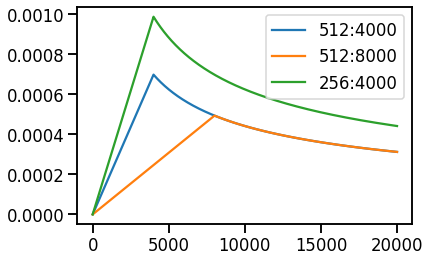

In [32]:
opts = [NoamOpt(512, 1, 4000, None), 
        NoamOpt(512, 1, 8000, None),
        NoamOpt(256, 1, 4000, None)]
plt.plot(np.arange(1, 20000), [[opt.rate(i) for opt in opts] for i in range(1, 20000)])
plt.legend(["512:4000", "512:8000", "256:4000"])

In [33]:
class LabelSmoothing(nn.Module):
    "Implement label smoothing."
    def __init__(self, size, padding_idx, smoothing=0.0):
        super(LabelSmoothing, self).__init__()
        self.criterion = nn.KLDivLoss(size_average=False)
        self.padding_idx = padding_idx
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.size = size
        self.true_dist = None
        
    def forward(self, x, target):
        assert x.size(1) == self.size
        true_dist = x.data.clone()
        true_dist.fill_(self.smoothing / (self.size - 2))
        true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
        true_dist[:, self.padding_idx] = 0
        mask = torch.nonzero(target.data == self.padding_idx)
        if mask.dim() > 0:
            true_dist.index_fill_(0, mask.squeeze(), 0.0)
        self.true_dist = true_dist
        return self.criterion(x, Variable(true_dist, requires_grad=False))

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


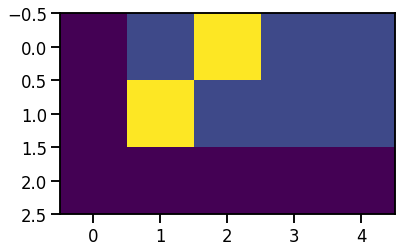

In [34]:
crit = LabelSmoothing(5, 0, 0.4)
predict = torch.FloatTensor([[0, 0.2, 0.7, 0.1, 0],
                             [0, 0.2, 0.7, 0.1, 0], 
                             [0, 0.2, 0.7, 0.1, 0]])
v = crit(Variable(predict.log()), 
         Variable(torch.LongTensor([2, 1, 0])))

# Show the target distributions expected by the system.
plt.imshow(crit.true_dist)

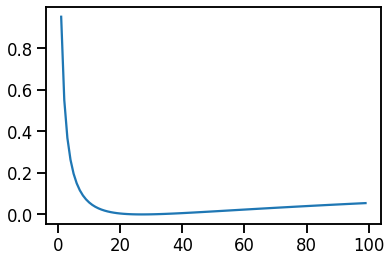

In [35]:
crit = LabelSmoothing(5, 0, 0.1)
def loss(x):
    d = x + 3 * 1
    predict = torch.FloatTensor([[0, x / d, 1 / d, 1 / d, 1 / d]])
    #print(predict)

    return crit(Variable(predict.log()),
                 Variable(torch.LongTensor([1]))).item()

plt.plot(np.arange(1, 100), [loss(x) for x in range(1, 100)])

In [53]:
def data_gen(V, batch, nbatches):
    "Generate random data for a src-tgt copy task."
    "这里生成的训练数据是随机数，序列src=tgt"
    for i in range(nbatches):
        data = torch.from_numpy(np.random.randint(1, V, size=(batch, 10)))
        data[:, 0] = 1
        src = Variable(data, requires_grad=False)
        tgt = Variable(data, requires_grad=False)
        yield Batch(src, tgt, 0)

In [37]:
class SimpleLossCompute:
    "A simple loss compute and train function."
    "计算loss，反向传播"
    def __init__(self, generator, criterion, opt=None):
        self.generator = generator
        self.criterion = criterion
        self.opt = opt
        
    def __call__(self, x, y, norm):
        x = self.generator(x)
        loss = self.criterion(x.contiguous().view(-1, x.size(-1)), 
                              y.contiguous().view(-1)) / norm
        loss.backward()
        if self.opt is not None:
            self.opt.step()
            self.opt.optimizer.zero_grad()
        return loss.data.item() * norm

In [44]:
# Train the simple copy task.
# 训练
V = 11
criterion = LabelSmoothing(size=V, padding_idx=0, smoothing=0.0)
model = make_model(V, V, N=2)
model_opt = NoamOpt(model.src_embed[0].d_model, 1, 400,
        torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))

for epoch in range(10):
    model.train()
    run_epoch(data_gen(V, 30, 20), model, 
              SimpleLossCompute(model.generator, criterion, model_opt))
    model.eval()
    #print(run_epoch(data_gen(V, 30, 5), model, 
                    #SimpleLossCompute(model.generator, criterion, None)))

<ipython-input-26-8c4144c2405f>:20: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(p)


Epoch Step: 1 Loss: 3.115075 Tokens per Sec: 513.839478
Epoch Step: 1 Loss: 2.011547 Tokens per Sec: 690.441040
Epoch Step: 1 Loss: 1.676219 Tokens per Sec: 656.485474
Epoch Step: 1 Loss: 1.486576 Tokens per Sec: 658.339844
Epoch Step: 1 Loss: 1.227973 Tokens per Sec: 658.915039
Epoch Step: 1 Loss: 0.666147 Tokens per Sec: 657.732849
Epoch Step: 1 Loss: 0.406398 Tokens per Sec: 611.234375
Epoch Step: 1 Loss: 0.376131 Tokens per Sec: 644.131470
Epoch Step: 1 Loss: 0.446200 Tokens per Sec: 650.477112
Epoch Step: 1 Loss: 0.660413 Tokens per Sec: 686.516235


In [46]:
def greedy_decode(model, src, src_mask, max_len, start_symbol):
    memory = model.encode(src, src_mask)
    ys = torch.ones(1, 1).fill_(start_symbol).type_as(src.data)
    for i in range(max_len-1):
        out = model.decode(memory, src_mask, 
                           Variable(ys), 
                           Variable(subsequent_mask(ys.size(1))
                                    .type_as(src.data)))
        prob = model.generator(out[:, -1])
        _, next_word = torch.max(prob, dim = 1)
        next_word = next_word.data[0]
        ys = torch.cat([ys, 
                        torch.ones(1, 1).type_as(src.data).fill_(next_word)], dim=1)
    return ys

model.eval()
src = Variable(torch.LongTensor([[1,2,3,1,2,3,7,8,9,10]]) )
src_mask = Variable(torch.ones(1, 1, 10) )
print(greedy_decode(model, src, src_mask, max_len=10, start_symbol=1))

tensor([[ 1,  2,  3,  1,  2,  3,  7,  8,  9, 10]])


In [ ]:

#!pip install torchtext spacy
#!python -m spacy download en
#!python -m spacy download de

In [47]:
model.eval()

EncoderDecoder(
  (encoder): Encoder(
    (layers): ModuleList(
      (0): EncoderLayer(
        (self_attn): MultiHeadedAttention(
          (linears): ModuleList(
            (0): Linear(in_features=512, out_features=512, bias=True)
            (1): Linear(in_features=512, out_features=512, bias=True)
            (2): Linear(in_features=512, out_features=512, bias=True)
            (3): Linear(in_features=512, out_features=512, bias=True)
          )
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (feed_forward): PositionwiseFeedForward(
          (w_1): Linear(in_features=512, out_features=2048, bias=True)
          (w_2): Linear(in_features=2048, out_features=512, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (sublayer): ModuleList(
          (0): SublayerConnection(
            (norm): LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): SublayerConnection(
            (norm): LayerNorm()

In [54]:
#torch.save(model,'transformer.model')